# Analyse pandas files

Purpose detection of bad files

work with Weakly_2023_11
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/04/04
- last update : 2023/04/04


In [1]:
import h5py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

In [3]:
import seaborn as sns
sns.set_style("ticks",{'axes.grid' : True})

In [4]:
import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
from astropy.time import Time
import astropy.units as u

In [6]:
DateToRuncollection = {

 # september 2022
 20220912 :  "u/dagoret/BPS_manyspectro_v60", # Missing collection
 20220913 :  "u/dagoret/BPS_manyspectro_v61", # Missing collection
 20220914 :  "u/dagoret/BPS_manyspectro_v62", # Missing collection  
 20220927 :  "u/dagoret/BPS_manyspectro_v63", # Mount errors available, mitigé
 20220928 :  "u/dagoret/BPS_manyspectro_v64", # Mount errors available, very nice spectra
 20220929 :  "u/dagoret/BPS_manyspectro_v65", # Mount errors available, very nice spectra
      
    
 # october 2022
 20221012 :  "u/dagoret/BPS_manyspectro_v56", # mount errors , nice
 20221025 :  "u/dagoret/BPS_manyspectro_v57", # mount errors, very bad spectra
 20221026 :  "u/dagoret/BPS_manyspectro_v58", # mount errors,  nice spectra
 20221027 :  "u/dagoret/BPS_manyspectro_v59", # mount errors,  nice spectra
    
 # november 2022
 20221109 :  "u/dagoret/BPS_manyspectro_v53", # nice
 20221110 :  "u/dagoret/BPS_manyspectro_v54", # mount errors available, many bad rec spectra
 20221123 :  "u/dagoret/BPS_manyspectro_v55", # mount errors , nice   
    
 # december 2022   
 20221207 :  "u/dagoret/BPS_manyspectro_v48",
 20221208 :  "u/dagoret/BPS_manyspectro_v49",
 20221209 :  "u/dagoret/BPS_manyspectro_v50", 
 20221210 :  "u/dagoret/BPS_manyspectro_v51", 
 20221212 :  "u/dagoret/BPS_manyspectro_v52",    
    
 #January 2023
 20230117 :  "u/dagoret/BPS_manyspectro_v79", # no mount errors
 20230118 :  "u/dagoret/BPS_manyspectro_v80", # no mount
 20230119 :  "u/dagoret/BPS_manyspectro_v77", # missing for moment
 20230131 :  "u/dagoret/BPS_manyspectro_v78", # missing for moment


 # february 2023
 20230214 :  "u/dagoret/BPS_manyspectro_v42",
 20230215 :  "u/dagoret/BPS_manyspectro_v43", # mount errors
 20230216 :  "u/dagoret/BPS_manyspectro_v44", # mount errors 
 20230228 :  "u/dagoret/BPS_manyspectro_v70",   
 
 # march 2023  
 20230301 :  "u/dagoret/BPS_manyspectro_v71", 
 20230302 :  "u/dagoret/BPS_manyspectro_v72", 
 20230315 :  "u/dagoret/BPS_manyspectro_v73", # mount errors
 20230316 :  "u/dagoret/BPS_manyspectro_v74", # mount errors   
    
}

In [7]:
DATE = 20230228 
filterdispersername = "empty~holo4_003"

In [8]:
configmode = "PSF2DFFM_REBIN2"
specver="specV2.4"

In [9]:
input_summary_file = f"fullsummaryspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.csv"
input_file_h5 = f"allspectra_{DATE}-{filterdispersername}-{configmode}-{specver}-oga.hdf5"

In [10]:
input_summary_file

'fullsummaryspectra_20230228-empty~holo4_003-PSF2DFFM_REBIN2-specV2.4-oga.csv'

# Read pandas file

In [11]:
df=pd.read_csv(input_summary_file,index_col=0)

In [12]:
df

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,spec_parallactic_angle,spec_camera_angle,spec_order,spec_header_target,spec_header_redshift,spec_header_grating,spec_header_rotangle,spec_header_d2ccd,spec_header_lshift,spec_header_parangle,spec_header_targetx,spec_header_targety,spec_header_lbda_ref,spec_header_pixshift,spec_header_psf_reg,spec_header_trace_r,spec_header_chi2_fit,spec_header_a2_fit,spec_header_am_fit,spec_header_meanfwhm,spec_header_version,spec_header_rebin,spec_header_date-obs,spec_header_exptime,spec_header_airmass,spec_header_dec,spec_header_ha,spec_header_outtemp,spec_header_outpress,spec_header_outhum,spec_header_filter,spec_header_cam_rot,spec_header_s_x0,spec_header_s_y0,spec_header_s_xmin,spec_header_s_xmax,spec_header_s_ymin,spec_header_s_ymax,spec_header_s_nx,spec_header_s_ny,spec_header_s_dec,spec_header_s_sat,spec_spectrogram_x0,spec_spectrogram_y0,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny
0,0,2023022800021,2023-03-01T00:18:20.108008730Z,HD73495,empty,1.191545,0,0,0,-37.359283,-105.828209,-74.186093,1,HD73495,0.000103,holo4_003,0.082317,186.648236,0.0,-105.828209,856.916462,1736.408962,550.000000,-0.866877,1.609024e-03,248.855932,2.892544,1.0,1.191545,5.907148,2.4,2,2023-03-01T00:18:20.108008730Z,30.0,1.191545,-26.211273,-37.359283,0,0,0,empty,-74.186093,-418.100070,86.408962,1278,1996,1650,1833,718,183,2,22666.666667,-418.100070,86.408962,1278,1996,1650,1833,2,22666.666667,718,183
1,1,2023022800022,2023-03-01T00:19:03.012506223Z,HD73495,empty,1.189476,0,0,0,-37.179896,-105.816679,-74.185935,1,HD73495,0.000103,holo4_003,0.282557,187.386222,0.0,-105.816679,147.080880,861.405239,550.000000,-0.923645,2.921208e-03,432.285523,16.217877,1.0,1.189476,5.425196,2.4,2,2023-03-01T00:19:03.012506223Z,30.0,1.189476,-26.211292,-37.179896,0,0,0,empty,-74.185935,-418.446249,87.405239,569,1706,774,959,1137,185,2,22666.666667,-418.446249,87.405239,569,1706,774,959,2,22666.666667,1137,185
2,2,2023022800026,2023-03-01T00:29:39.402009758Z,HD73495,empty,1.160501,0,0,0,-34.521047,-105.690156,-74.378782,1,HD73495,0.000103,holo4_003,0.264691,187.613443,0.0,-105.690156,145.450044,861.641479,550.000000,-1.991906,6.088355e-02,260.432774,87.266422,1.0,1.160501,6.980281,2.4,2,2023-03-01T00:29:39.402009758Z,30.0,1.160501,-26.211430,-34.521047,0,0,0,empty,-74.378782,-419.124253,87.641479,570,1707,774,959,1137,185,2,22666.666667,-419.124253,87.641479,570,1707,774,959,2,22666.666667,1137,185
3,3,2023022800027,2023-03-01T00:30:22.308501423Z,HD73495,empty,1.158668,0,0,0,-34.341853,-105.684878,-74.378803,1,HD73495,0.000103,holo4_003,0.236995,184.710031,0.0,-105.684878,148.959147,862.132173,550.000000,0.000000,8.871560e-09,835.875309,21.757219,1.0,1.158668,7.049007,2.4,2,2023-03-01T00:30:22.308501423Z,30.0,1.158668,-26.211408,-34.341853,0,0,0,empty,-74.378803,-418.193787,88.132173,569,1705,774,959,1136,185,2,22666.666667,-418.193787,88.132173,569,1705,774,959,2,22666.666667,1136,185
4,4,2023022800039,2023-03-01T00:40:14.104491209Z,HD185975,empty,2.117374,0,0,0,-208.784624,151.879997,29.150825,1,HD185975,-0.000065,holo4_003,0.514196,187.313701,0.0,151.879997,155.354202,880.562860,597.257159,0.068920,5.508870e-01,256.355429,7.682273,1.0,2.117374,5.723056,2.4,2,2023-03-01T00:40:14.104491209Z,30.0,2.117374,-87.498698,-208.784624,0,0,0,empty,29.150825,-416.954733,82.562860,572,1709,798,983,1137,185,2,22666.666667,-416.954733,82.562860,572,1709,798,983,2,22666.666667,1137,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,2023022800323,2023-03-01T04:49:29.664007787Z,HD73495,empty,1.122633,0,0,0,30.628205,105.513

# Cut

In [13]:
chi2_fit_max = 25
chi2_fit_min = 0

d2ccd_max = 188
d2ccd_min = 186.6

pixshift_max = 0.3
pixshift_min = -0.3

In [14]:
cut1 = (df['spec_header_chi2_fit'] >= chi2_fit_min ) & (df['spec_header_chi2_fit'] <= chi2_fit_max )
cut2 = (df['spec_header_d2ccd'] >= d2ccd_min ) & (df['spec_header_d2ccd'] < d2ccd_max )
cut3 = (df['spec_header_pixshift'] >= pixshift_min ) & (df['spec_header_pixshift'] < pixshift_max )

# Control plots

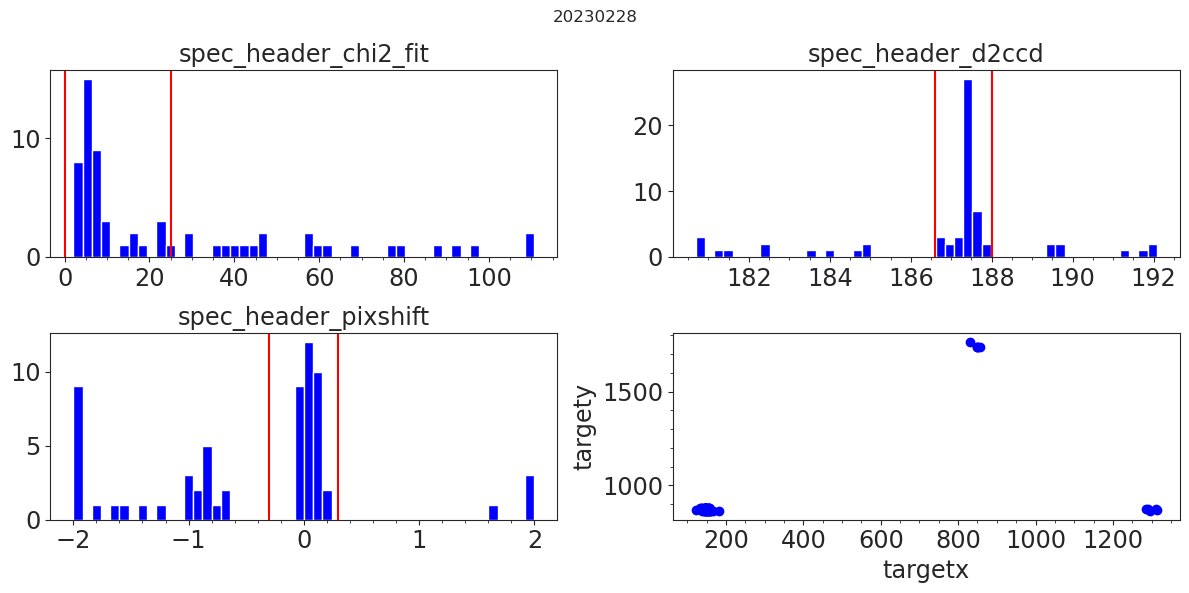

In [15]:
fig = plt.figure(figsize=(12,6))
axes = fig.subplots(2,2)
all_names = ['spec_header_chi2_fit','spec_header_d2ccd','spec_header_pixshift']
all_minval = [chi2_fit_min, d2ccd_min, pixshift_min ]
all_maxval = [chi2_fit_max, d2ccd_max, pixshift_max ]

for i, ax in enumerate(axes.flat):    
    if i <=2: 
        name = all_names[i]
        nbins=50
        values = df[name].values
        ax.hist(values,bins=nbins,facecolor="blue")
        ax.set_title(name)
        ax.grid()
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.axvline(all_minval[i],color="r")
        ax.axvline(all_maxval[i],color="r")
        
    if i == 3:
        xval=df["spec_header_targetx"].values
        yval=df["spec_header_targety"].values
        ax.scatter(xval,yval,color="blue")
        ax.set_xlabel("targetx")
        ax.set_ylabel("targety")
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.grid()
plt.suptitle(DATE)
plt.tight_layout()
plt.show()    

In [16]:
df_cut1 = df[['spec_header_chi2_fit','spec_header_d2ccd','spec_header_pixshift']]
df_cut2 = df[['spec_header_targetx','spec_header_targety']]

<Figure size 1400x1400 with 0 Axes>

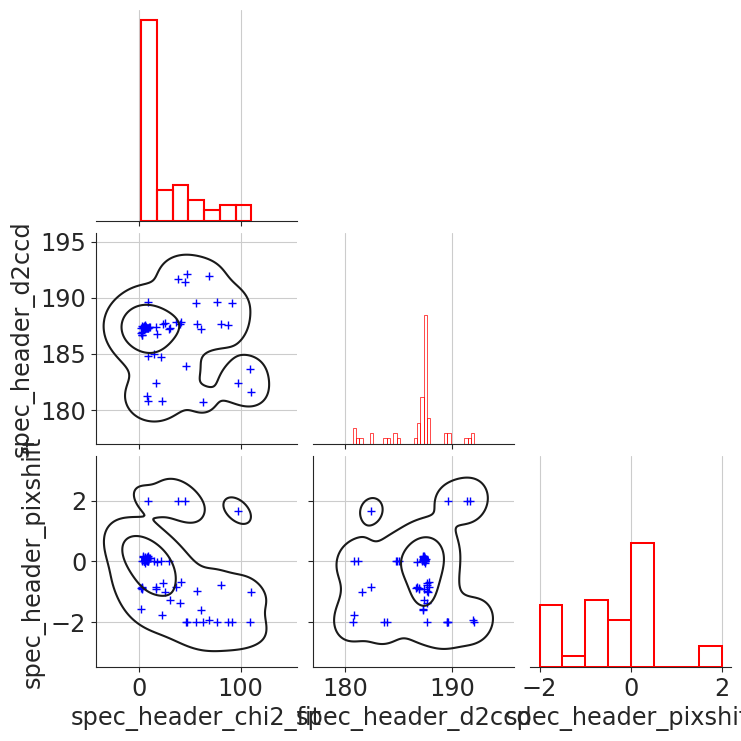

In [17]:
plt.figure(figsize=(14,14))
g=sns.pairplot(df_cut1,corner=True,plot_kws=dict(marker="+", linewidth=1,color="b"),
             diag_kws=dict(color="r",fill=False),)
g.map_lower(sns.kdeplot, levels=3, color=".1")
plt.show()

<Figure size 1600x1600 with 0 Axes>

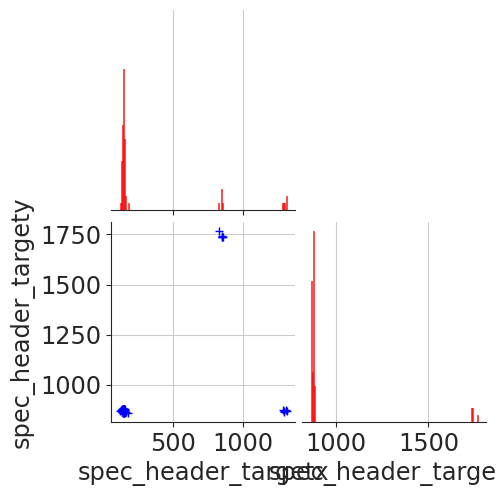

In [18]:
plt.figure(figsize=(16,16))
sns.pairplot(df_cut2,corner=True,plot_kws=dict(marker="+", linewidth=1,color="b"),
             diag_kws=dict(color="r",fill=False),)
plt.show()

KeyError: 'me_az_rms'

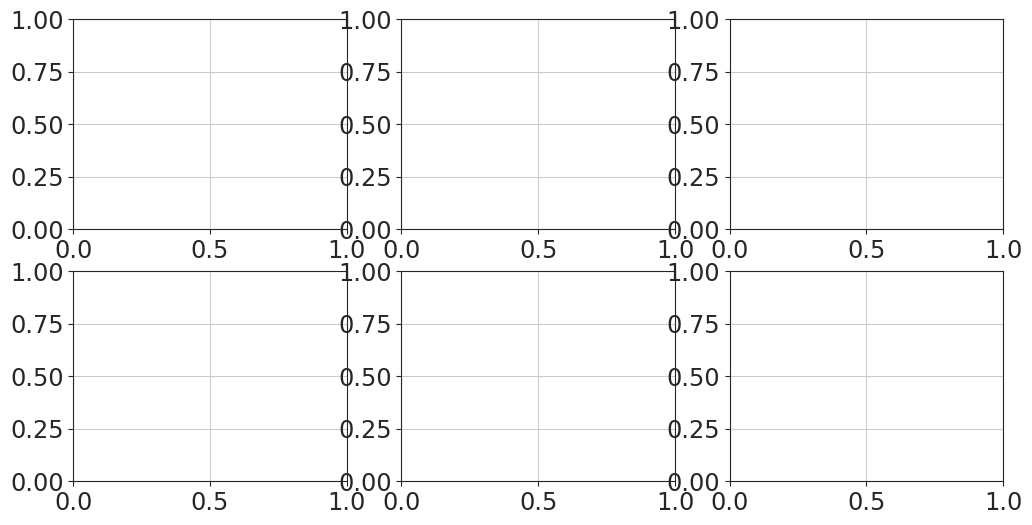

In [19]:
fig = plt.figure(figsize=(12,6))
axes = fig.subplots(2,3)
all_names = ["me_az_rms","me_el_rms","me_rot_rms","me_image_az_rms","me_image_el_rms","me_image_rot_rms"]

for i, ax in enumerate(axes.flat):    
    name = all_names[i]
    nbins=50
    values =  df[name].values
    ax.hist(values,bins=nbins,facecolor="blue")
    ax.set_title(name)
    ax.grid()
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    
plt.suptitle(DATE)
plt.tight_layout()
plt.show()    

In [ ]:
df_cut3 =df[all_names]

In [ ]:
plt.figure(figsize=(14,14))
sns.pairplot(df_cut3,corner=True,plot_kws=dict(marker="+", linewidth=1,color="b"),
             diag_kws=dict(color="r",fill=False),)
plt.title(DATE)
plt.show()

# Selection of Bads and goods

In [20]:
df[~(cut1 & cut2 & cut3)]

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,spec_parallactic_angle,spec_camera_angle,spec_order,spec_header_target,spec_header_redshift,spec_header_grating,spec_header_rotangle,spec_header_d2ccd,spec_header_lshift,spec_header_parangle,spec_header_targetx,spec_header_targety,spec_header_lbda_ref,spec_header_pixshift,spec_header_psf_reg,spec_header_trace_r,spec_header_chi2_fit,spec_header_a2_fit,spec_header_am_fit,spec_header_meanfwhm,spec_header_version,spec_header_rebin,spec_header_date-obs,spec_header_exptime,spec_header_airmass,spec_header_dec,spec_header_ha,spec_header_outtemp,spec_header_outpress,spec_header_outhum,spec_header_filter,spec_header_cam_rot,spec_header_s_x0,spec_header_s_y0,spec_header_s_xmin,spec_header_s_xmax,spec_header_s_ymin,spec_header_s_ymax,spec_header_s_nx,spec_header_s_ny,spec_header_s_dec,spec_header_s_sat,spec_spectrogram_x0,spec_spectrogram_y0,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny
0,0,2023022800021,2023-03-01T00:18:20.108008730Z,HD73495,empty,1.191545,0,0,0,-37.359283,-105.828209,-74.186093,1,HD73495,0.000103,holo4_003,0.082317,186.648236,0.0,-105.828209,856.916462,1736.408962,550.0,-0.866877,1.609024e-03,248.855932,2.892544,1.0,1.191545,5.907148,2.4,2,2023-03-01T00:18:20.108008730Z,30.0,1.191545,-26.211273,-37.359283,0,0,0,empty,-74.186093,-418.100070,86.408962,1278,1996,1650,1833,718,183,2,22666.666667,-418.100070,86.408962,1278,1996,1650,1833,2,22666.666667,718,183
1,1,2023022800022,2023-03-01T00:19:03.012506223Z,HD73495,empty,1.189476,0,0,0,-37.179896,-105.816679,-74.185935,1,HD73495,0.000103,holo4_003,0.282557,187.386222,0.0,-105.816679,147.080880,861.405239,550.0,-0.923645,2.921208e-03,432.285523,16.217877,1.0,1.189476,5.425196,2.4,2,2023-03-01T00:19:03.012506223Z,30.0,1.189476,-26.211292,-37.179896,0,0,0,empty,-74.185935,-418.446249,87.405239,569,1706,774,959,1137,185,2,22666.666667,-418.446249,87.405239,569,1706,774,959,2,22666.666667,1137,185
2,2,2023022800026,2023-03-01T00:29:39.402009758Z,HD73495,empty,1.160501,0,0,0,-34.521047,-105.690156,-74.378782,1,HD73495,0.000103,holo4_003,0.264691,187.613443,0.0,-105.690156,145.450044,861.641479,550.0,-1.991906,6.088355e-02,260.432774,87.266422,1.0,1.160501,6.980281,2.4,2,2023-03-01T00:29:39.402009758Z,30.0,1.160501,-26.211430,-34.521047,0,0,0,empty,-74.378782,-419.124253,87.641479,570,1707,774,959,1137,185,2,22666.666667,-419.124253,87.641479,570,1707,774,959,2,22666.666667,1137,185
3,3,2023022800027,2023-03-01T00:30:22.308501423Z,HD73495,empty,1.158668,0,0,0,-34.341853,-105.684878,-74.378803,1,HD73495,0.000103,holo4_003,0.236995,184.710031,0.0,-105.684878,148.959147,862.132173,550.0,0.000000,8.871560e-09,835.875309,21.757219,1.0,1.158668,7.049007,2.4,2,2023-03-01T00:30:22.308501423Z,30.0,1.158668,-26.211408,-34.341853,0,0,0,empty,-74.378803,-418.193787,88.132173,569,1705,774,959,1136,185,2,22666.666667,-418.193787,88.132173,569,1705,774,959,2,22666.666667,1136,185
6,6,2023022800054,2023-03-01T00:52:17.532996066Z,HD73495,empty,1.108807,0,0,0,-28.840815,-105.764438,-74.344325,1,HD73495,0.000103,holo4_003,0.025077,186.721844,0.0,-105.764438,848.306397,1737.968953,550.0,-0.847334,1.137300e-02,187.165715,2.423577,1.0,1.108807,6.859341,2.4,2,2023-03-01T00:52:17.532996066Z,30.0,1.108807,-26.212869,-28.840815,0,0,0,empty,-74.344325,-418.832260,87.968953,1270,1996,1650,1833,726,183,2,22666.666667,-418.832260,87.968953,1270,1996,1650,1833,2,22666.666667,726,183
7,7,2023022800055,2023-03-01T00:53:00.538997518Z,HD73495,empty,1.107377,0,0,0,-28.661243,-105.776649,-74.344369,1,HD73495,0.000103,holo4_003,0.256386,187.658792,0.0,-105.776649,137.536679,863.575494,550.0,-0.717839,2.263993e-02,324.057643,23.145910,1.0,1.107377,5.392029,2.4,2,2023-03-01T00:53:00.538997518Z,30.0,1.107377,-26.212838,-28.661243,0,0,0,empty,-74.344369,-4

In [21]:
df[(cut1 & cut2 & cut3)]

,index,exposure,spec_date_obs,spec_target_label,spec_filter_label,spec_airmass,spec_pressure,spec_temperature,spec_humidity,spec_hour_angle,spec_parallactic_angle,spec_camera_angle,spec_order,spec_header_target,spec_header_redshift,spec_header_grating,spec_header_rotangle,spec_header_d2ccd,spec_header_lshift,spec_header_parangle,spec_header_targetx,spec_header_targety,spec_header_lbda_ref,spec_header_pixshift,spec_header_psf_reg,spec_header_trace_r,spec_header_chi2_fit,spec_header_a2_fit,spec_header_am_fit,spec_header_meanfwhm,spec_header_version,spec_header_rebin,spec_header_date-obs,spec_header_exptime,spec_header_airmass,spec_header_dec,spec_header_ha,spec_header_outtemp,spec_header_outpress,spec_header_outhum,spec_header_filter,spec_header_cam_rot,spec_header_s_x0,spec_header_s_y0,spec_header_s_xmin,spec_header_s_xmax,spec_header_s_ymin,spec_header_s_ymax,spec_header_s_nx,spec_header_s_ny,spec_header_s_dec,spec_header_s_sat,spec_spectrogram_x0,spec_spectrogram_y0,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny
4,4,2023022800039,2023-03-01T00:40:14.104491209Z,HD185975,empty,2.117374,0,0,0,-208.784624,151.879997,29.150825,1,HD185975,-0.000065,holo4_003,0.514196,187.313701,0.0,151.879997,155.354202,880.562860,597.257159,0.068920,5.508870e-01,256.355429,7.682273,1.0,2.117374,5.723056,2.4,2,2023-03-01T00:40:14.104491209Z,30.0,2.117374,-87.498698,-208.784624,0,0,0,empty,29.150825,-416.954733,82.562860,572,1709,798,983,1137,185,2,22666.666667,-416.954733,82.562860,572,1709,798,983,2,22666.666667,1137,185
5,5,2023022800040,2023-03-01T00:40:57.110992661Z,HD185975,empty,2.117654,0,0,0,-208.604971,152.055794,29.150967,1,HD185975,-0.000065,holo4_003,0.506727,187.353000,0.0,152.055794,155.874876,880.074443,597.257159,0.097123,1.339484e+00,213.015417,10.023006,1.0,2.117654,5.518087,2.4,2,2023-03-01T00:40:57.110992661Z,30.0,2.117654,-87.498691,-208.604971,0,0,0,empty,29.150967,-417.514759,83.074443,573,1710,797,982,1137,185,2,22666.666667,-417.514759,83.074443,573,1710,797,982,2,22666.666667,1137,185
14,14,2023022800095,2023-03-01T01:18:43.464502763Z,HD185975,empty,2.130891,0,0,0,-199.001310,161.447224,19.711137,1,HD185975,-0.000065,holo4_003,0.504779,187.374168,0.0,161.447224,155.515772,877.018767,597.257159,0.008460,7.301927e-01,221.071488,5.229537,1.0,2.130891,6.528559,2.4,2,2023-03-01T01:18:43.464502763Z,30.0,2.130891,-87.492496,-199.001310,0,0,0,empty,19.711137,-417.685325,83.018767,573,1710,794,979,1137,185,2,22666.666667,-417.685325,83.018767,573,1710,794,979,2,22666.666667,1137,185
15,15,2023022800096,2023-03-01T01:19:26.374500538Z,HD185975,empty,2.131089,0,0,0,-198.822065,161.622363,19.711300,1,HD185975,-0.000065,holo4_003,0.499299,187.342053,0.0,161.622363,157.220569,877.185288,597.257159,0.159208,4.625141e-01,215.402361,4.179350,1.0,2.131089,7.401686,2.4,2,2023-03-01T01:19:26.374500538Z,30.0,2.131089,-87.492502,-198.822065,0,0,0,empty,19.711300,-418.108739,83.185288,575,1711,794,979,1136,185,2,22666.666667,-418.108739,83.185288,575,1711,794,979,2,22666.666667,1136,185
20,20,2023022800124,2023-03-01T01:38:37.279990491Z,HD185975,empty,2.136531,0,0,0,-193.783455,166.545609,14.797689,1,HD185975,-0.000065,holo4_003,0.506861,187.375768,0.0,166.545609,148.612277,876.597199,597.257159,0.143211,4.547262e-01,243.006328,5.296935,1.0,2.136531,6.171329,2.4,2,2023-03-01T01:38:37.279990491Z,30.0,2.136531,-87.481363,-193.783455,0,0,0,empty,14.797689,-417.754624,82.597199,566,1703,794,979,1137,185,2,22666.666667,-417.754624,82.597199,566,1703,794,979,2,22666.666667,1137,185
21,21,2023022800125,2023-03-01T01:39:20.178993247Z,HD185975,empty,2.136686,0,0,0,-193.604091,166.720758,14.797583,1,HD185975,-0.000065,holo4_003,0.509661,187.401910,0.0,166.720758,147.725929,875.688131,597.257159,0.172930,2.019819e-01,248.644750,3.709548,1.0,2.136686,6.351855,2.4,2,2023-03-01T01:39:20.178993247Z,30.0,2.136686,-87.481361,-193.60409